# Lab6 DBSCAN

This week's exercise will focus on density-based clustering using DBSCAN

Schedule:
* Implement the core of DBSCAN
* Clustering visualizations

In [1]:
# ! git pull

In [2]:
# Makes matplotlib plots work better with Jupyter
%matplotlib inline

# Import the necessary libraries. 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None

## Take a look at the data

In [3]:
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.1)
# scatter plot, dots colored by class value
data = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1]))

features = ['x0', 'x1']

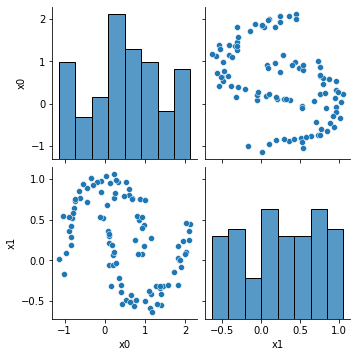

In [4]:
# When plotting, choose a high contrast color pallette (possibly colorblind-friendly :) )
sns.pairplot(data, vars=features)

The scatter plot visually shows two distincts clusters. Let's see what happens when we try to partition the data with K-means (implemented in `sklearn.clusters`). Let's set K to 2.

In [5]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data[features])
data['KMeansClusters'] = pd.Series(kmeans.labels_)

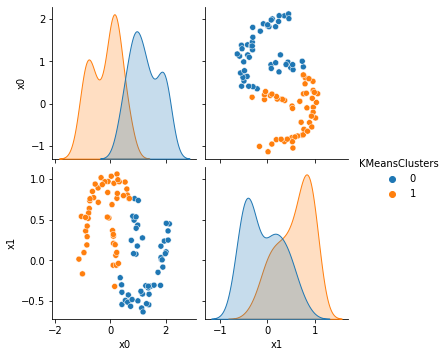

In [6]:
sns.pairplot(data, vars=features, hue='KMeansClusters')

As you can see, K-Means is not an appropriate clustering algorithm for this kind of dataset. Let's implement **DBSCAN**, a density-based algorithm, and see if we can achieve better results (Spoiler: we will :D ). 

# DBSCAN - todotodotodotodotodotodotodotodotodotodotodo

0. pick a value for K (number of clusters)
1. standardize fields (Reminder: subtract by mean, then divide by standard deviation)
2. create K random centroids as arrays with size the number of features
3. foreach `datapoint` in `data`:
  1. set as `centroid` of `datapoint` the closest `centroid`
  2. if at least one `centroid` has changed: goto 3
  
### Tips
- the computations needed for k-means are expensive, test on a small subset of the data to save time (5/10 to check calculations on single rows, 50/100 to check the correctness of the whole algorithm)
- you'll need to compute a distance at a certain point, check Lab3
- [DataFrame.idxmin](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html]) will give you the index of the smallest entry in a dataset
- `dataFrame1 is dataFrame2` is not correct (it checks if the two objects are the same, not if they contain the same values). The correct approach is `dataFrame1.equals(dataFrame2)` (or `dataFrame1['aColumn'].equals(dataFrame2['aColumn'])` ;))
- You can apply a function to every element/row/column of a dataframe by using the `apply` pandas function
- To update the values of the centroids, you might find the combination of `groupby` and `mean` to be useful.
### Reminders:
- Euclidian Distance:
$$ d_e(a, b) = \sqrt{\sum_{i=1}^m{{(a_i-b_i)}^2}}$$
- Minkowski Distance:
$$ d_m(a, b) = \sqrt[q]{\sum_{i=1}^m{{\lvert a_i-b_i \rvert}^q}}$$
- Chebyshev Distance:
$$ d_c(a, b) = \max(\lvert a_1-b_1 \rvert, \lvert a_2-b_2 \rvert, ..., \lvert a_m-b_m \rvert)$$

In [ ]:
# 0: define K
K = 5

In [ ]:
# 1: Standardize features
data[features] = data[features].sub(data[features].mean(axis=0)).divide(data[features].std(axis=0))

In [ ]:
def k_means_clustering(data, max_iter=-1):
    
    # Inizialize the centroids by sampling K elements from the data (do you remember the pandas sample function? :D)
    # Then, remember to reset the indeces of the new centroids dataframe without introducing new columns
    # (there's a pandas function for that as well :D)
    ## YOUR CODE HERE
    centroids = data[features].sample(K)
    centroids = centroids.reset_index(drop=True)
    
    # Implement the function assign_centroid that assigns the index of the closest centroid (Euclidian Distance)
    def assign_centroid_euclidian(x):
        ## YOUR CODE HERE
        x['Centroid'] = centroids.sub(x[features]) \
            .pow(2).sum(1).pow(0.5) \
            .idxmin(0)
        return x
    
    # Implement the function assign_centroid that assigns the index of the closest centroid (Minkowski Distance)
    q = 1 # e.g.: q=1 -> Manhattan Distance
    def assign_centroid_minkowski(x):
        ## YOUR CODE HERE
        x['Centroid'] = centroids.sub(x[features]) \
            .abs().pow(q).sum(1).pow(1/q) \
            .idxmin(0)
        return x
    
    # Implement the function assign_centroid that assigns the index of the closest centroid (Chebyshev Distance)
    def assign_centroid_chebyshev(x):
        ## YOUR CODE HERE
        x['Centroid'] = centroids.sub(x[features]) \
            .abs().max(1) \
            .idxmin(0)
        return x

    iter = 0
    data = data.assign(Centroid=pd.Series([-1] * len(data)), OldCentroid=pd.Series([0] * len(data)))

    # Implement the actual K-means loop:
    while not data['Centroid'].equals(data['OldCentroid']):
        ## YOUR CODE HERE
        print(f'iter {iter}')
        
        data['OldCentroid'] = data['Centroid']
        data = data.apply(assign_centroid_euclidian, axis=1)
        # data = data.apply(assign_centroid_minkowski, axis=1)
        # data = data.apply(assign_centroid_chebyshev, axis=1)
        centroids = data.groupby('Centroid').mean()[features]
        centroids.reset_index()
        
        iter += 1
        if max_iter > -1 and iter >= max_iter:
            break
    
    print('done')
    return data[features+['Centroid']], centroids


In [ ]:
new_data, new_centroids = k_means_clustering(data.head(50))

In [ ]:
new_data

In [ ]:
new_centroids

# Clusters visualization
The most difficult task with clustering is understand if the clustering makes sense and what the clustering means. If the dimensionality is low, a good idea is to use a pairplot and see if the clusters are really close in each slice. The closer they are, the better.

In [ ]:
# When plotting, choose a high contrast color pallette (possibly colorblind-friendly :) )
sns.pairplot(new_data, vars=features, hue='Centroid', palette=sns.color_palette("colorblind", K))